1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [1]:
# assuming as null hypothesis a poisson distribution with mean = 6.3, 
# normal for large samples with mean = 6.3, and std  = 6.3
import numpy as np
mu = 6.3
std = np.sqrt(6.3)
obs = 15
Z = (obs-mu)/std
print('Z = ', Z)

Z =  3.4661629670697414


In [2]:
# let us find the corresponding confidence level, if we assume that the sample is
# statistically different with a Z > 3
# plot the test statistics and its pdf
#one tail
import scipy.stats as stats
alpha = (1. - stats.norm.cdf(3))
print('alpha = ', alpha)
# if we find a p-value < alpha, we reject the null hypothesis

alpha =  0.0013498980316301035


p-value =  0.00026397158691493505 
 alpha =  0.0013498980316301035 we reject the null hypothesis


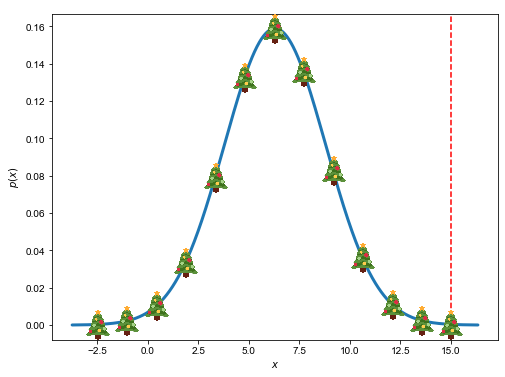

In [3]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.set_theme(style='white', font_scale=1.5)
lw=3
nstd=4
x=np.linspace(mu-nstd*std,mu+nstd*std,1000)
dist = stats.norm(mu, std).pdf(x)
sns.lineplot(y=dist,x=x, ax=ax, lw=lw)
ax.axvline(obs, linestyle='--', color='red')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

# merry christmas
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

image = plt.imread('albero.png')
image_box = OffsetImage(image, zoom=0.06)
x=np.linspace(-2.5,15,13)
for x0, y0 in zip(x, stats.norm(mu, std).pdf(x)):
    ab = AnnotationBbox(image_box, (x0, y0), frameon=False)
    ax.add_artist(ab)

#------------------------------------------------------------------------------
pvalue = 1-stats.norm.cdf(Z) #onetail
print('p-value = ', pvalue, '\n', 'alpha = ', alpha,\
     'we reject the null hypothesis')

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [4]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])

In [5]:
# Determine whether the change in blood pressures 
# within our sample was statistically significant.
mupre = np.average(pre)
stdpre = np.std(pre)
mupost = np.average(post)
stdpost = np.std(post)

#test t student on two samples with null hypothesis 'equal distributions'
std = np.sqrt((stdpre**2 + stdpost**2)/2) 
t = (mupre - mupost) / (std * np.sqrt(2/len(pre)))
p = stats.t.cdf(t, len(pre)-1)
print('t = ', t, 'p = ', p)

scipy_t, scipy_p = stats.ttest_ind(pre, post)
print('scipy_t = ', scipy_t, 'scipy_p = ', scipy_p)

t =  -3.991846326292112 p =  0.0015744704677267873
scipy_t =  -3.786997938137629 scipy_p =  0.00134994183132767


we fix a confidence level $\alpha = 0.01$.
With such confidence we can reject the null hypothesis that the two datasets are sampled fromt he same distribution, since the p-value is less than $\alpha$.

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

Text(0, 0.5, 'population')

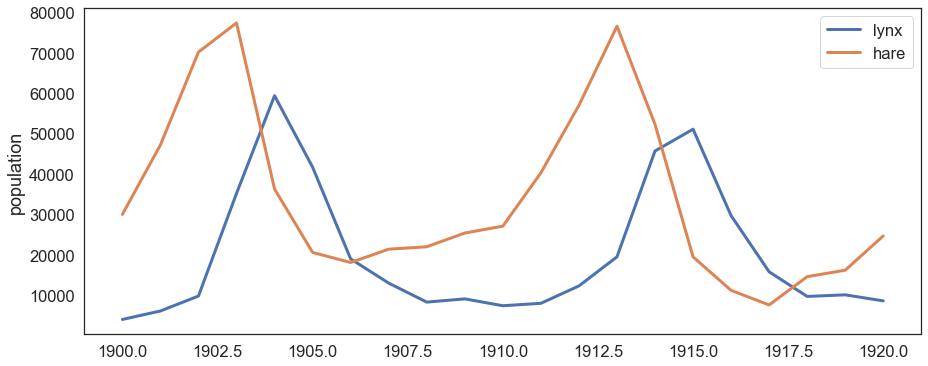

In [6]:
import pandas as pd
year, hare, lynx, carrots = np.loadtxt('populations.txt', unpack = True) 

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.set_theme(style='white', font_scale=1.5, palette ='Dark2')
sns.lineplot(x=year, y=lynx, ax=ax, lw=lw, label = 'lynx')
sns.lineplot(x=year, y=hare, ax=ax, lw=lw, label = 'hare')
ax.set_ylabel('population')

Peak frequency lynx: 0.09523809523809523
Peak frequency hare: 0.09523809523809523
period lynx =  10.5
period hare =  10.5


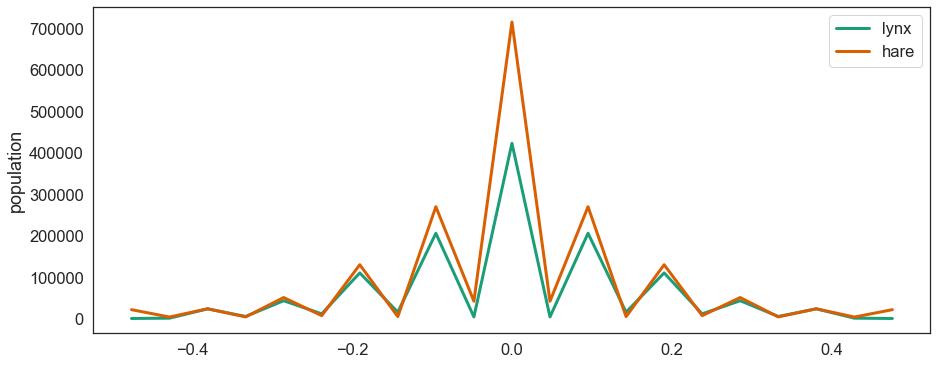

In [7]:
from scipy import fftpack

fftlynx = fftpack.fft(list(lynx))
ffthare = fftpack.fft(list(hare))

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
freq = fftpack.fftfreq(year.size, d=1)
fftlynx_pow = np.abs(fftlynx)
ffthare_pow = np.abs(ffthare)

sns.set_theme(style='white', font_scale=1.5, palette ='Dark2')
sns.lineplot(x=freq, y=fftlynx_pow, ax=ax, lw=lw, label = 'lynx')
sns.lineplot(x=freq, y=ffthare_pow, ax=ax, lw=lw, label = 'hare')
ax.set_ylabel('population')

pos_mask = np.where(freq > 0)
pfreq = freq[pos_mask]
peak_freq_lynx = pfreq[fftlynx_pow[pos_mask].argmax()]
peak_freq_hare = pfreq[ffthare_pow[pos_mask].argmax()]

print("Peak frequency lynx:", peak_freq_lynx)
print("Peak frequency hare:", peak_freq_hare)
print('period lynx = ', 1./peak_freq_lynx)
print('period hare = ', 1./peak_freq_hare)

Text(0.5, 0, 'year')

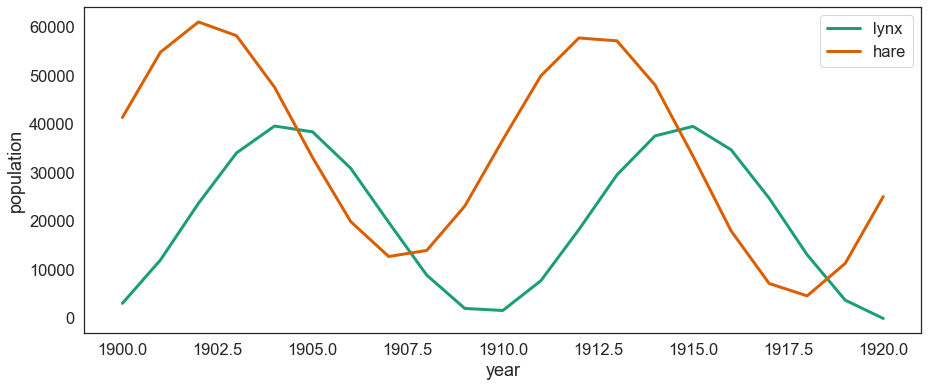

In [8]:
fcleaned_lynx =fftlynx.copy()
fcleaned_lynx[np.abs(freq) > peak_freq_lynx] = 0
fcleaned_hare = ffthare.copy()
fcleaned_hare[np.abs(freq) > peak_freq_hare] = 0
cleaned_lynx = fftpack.ifft(list(fcleaned_lynx))
cleaned_hare = fftpack.ifft(list(fcleaned_hare))
real_clean_lynx = np.real(cleaned_lynx)
real_clean_hare = np.real(cleaned_hare)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.set_theme(style='white', font_scale=1.5, palette ='Dark2')
sns.lineplot(x=year, y=real_clean_lynx, ax=ax, lw=lw, label = 'lynx')
sns.lineplot(x=year, y=real_clean_hare, ax=ax, lw=lw, label = 'hare')
ax.set_ylabel('population')
ax.set_xlabel('year')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

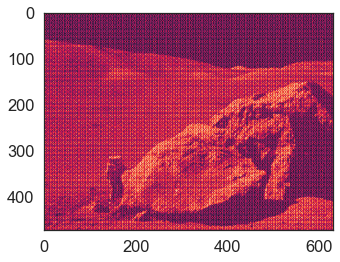

In [9]:
# * Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. 
# Examine the image with `plt.imshow()`, 
# which is heavily contaminated with periodic noise.
image=plt.imread("moonlanding.png")
plt.imshow(image)

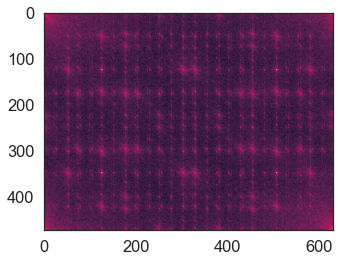

In [10]:
from matplotlib.colors import LogNorm
import scipy.fftpack as fft
# find the method that performs a 2D FFT. Plot the spectrum 
# (Fourier transform of) the image. 
# **Hint**: use `LogNorm` to plot the colors in log scale:

fftimage = fft.fft2(image)
power = np.abs(fftimage)
plt.imshow(power, norm=LogNorm(vmin=5))

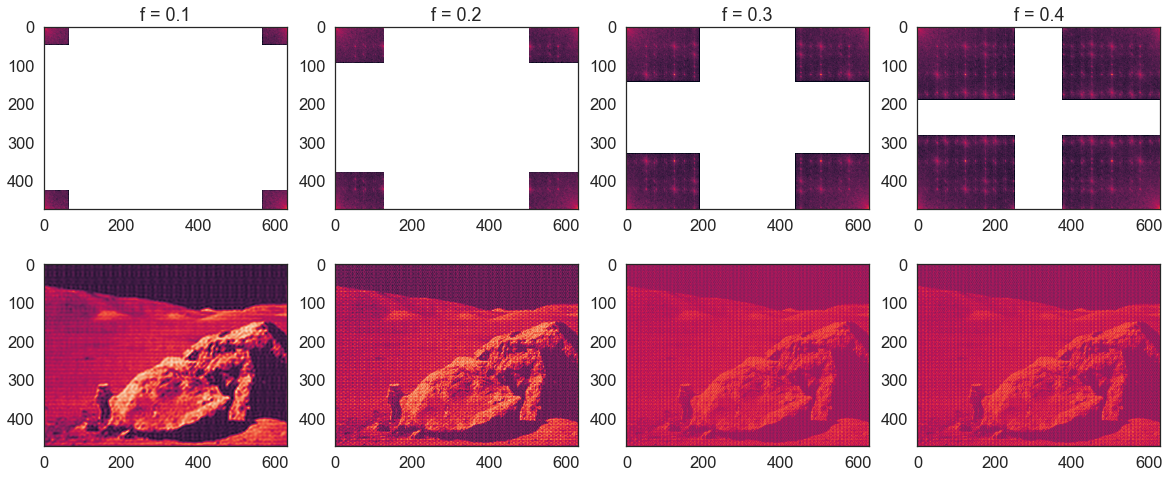

In [11]:
# Inspect the spectrum, and try to locate the regions of the power 
# spectrum that contain the signal and those which contain the periodic noise. 
# Use array slicing to set the noise regions to zero

# fraction of coefficients to save
filters = [0.1, 0.2, 0.3, 0.4]
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
rows, cols = fftimage.shape

j = 0
for i in range(len(filters)):
    f = filters[i]
    fftcopy = fftimage.copy()
    fftcopy[int(rows*f):int(rows*(1-f))] = 0
    fftcopy[:, int(cols*f):int(cols*(1-f))] = 0
    ax[0, i].imshow(np.abs(fftcopy), norm=LogNorm(vmin=5))
    ax[0, i].set_title('f = ' + str(f))
    cleanimage = fftpack.ifft2(fftcopy).real
    ax[1, i].imshow(cleanimage)
